# Evaluate Model Predictions

In [1]:
import pandas as pd
import numpy as np
import tqdm
import os

Load model predictions

In [2]:
subset = "full"
species = "mouse_rat"
loss = "weighted_mse"
model = f"{subset}_{species}_{loss}"

# Load test metadata
data_dir = f"/home/elek/sds/sd17d003/Anamaria/splicevo/data/"
data_path = os.path.join(data_dir, f"splits_{subset}", f"{species}", "test")

from splicevo.utils.data_utils import load_processed_data
test_seq, test_labels, test_alpha, test_beta, test_sse, test_species = load_processed_data(data_path)

meta_fn = os.path.join(data_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    test_meta = json.load(f)

# Test windows metadata
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn)

# Species
species_name_to_id = test_meta['species_mapping']
species_id_to_name = {v: k for k, v in species_name_to_id.items()}

# Load predictions
pred_dir = "/home/elek/sds/sd17d003/Anamaria/splicevo/predictions/"
pred_path = os.path.join(pred_dir, model)

from splicevo.utils.data_utils import load_predictions
pred_labels, pred_probs, pred_sse, meta, true_labels, true_sse = load_predictions(pred_path)

# Load metadata
meta_fn = os.path.join(pred_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    meta = json.load(f)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Splice site classification

Inspect predictions vs true labels for the first few sequences.

In [3]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(true_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_labels[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(true_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_labels[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       []
  predicted    [24, 33, 213, 239, 317, 359, 441, 450, 454, 492, 502, 661, 702, 714, 722, 782, 791, 818, 827, 829, 835, 851, 855, 859, 883, 900, 904, 921, 953, 970, 973, 983, 991, 993]
(2) Acceptor splice sites in sequence 0:
  actual    [0]
  predicted [0, 37, 67, 94, 114, 133, 172, 205, 250, 322, 358, 395, 430, 559, 629, 669, 701, 726, 729, 840, 843, 852, 856, 858, 862, 866, 871, 876, 882, 884, 892, 894, 896, 903, 911, 917, 940, 954, 962, 964, 971, 998]

(1) Donor splice sites in sequence 1:
  actual       [520]
  predicted    [61, 78, 118, 230, 246, 266, 272, 276, 300, 314, 336, 351, 355, 359, 397, 403, 407, 453, 492, 520, 521, 556, 589, 609, 806, 815, 825, 988]
(2) Acceptor splice sites in sequence 1:
  actual    [688]
  predicted [2, 38, 45, 119, 148, 196, 227, 261, 265, 279, 280, 313, 352, 398, 417, 440, 449, 490, 493, 524, 661, 688, 744, 753, 787, 788, 842]

(1) Donor splice sites in sequence 2:
  actual       [595, 646]
  

In [4]:
for i, j in [(0, 0), (0, 1), (1, 21), (2, 13)]:
    print(f"Sequence {i}, position {j}:\n  true label: {true_labels[i,j]}\n  pred label: {pred_labels[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 2
  pred label: 2
  porbs:[6.2652759e-04 1.2433554e-04 9.9924904e-01]
Sequence 0, position 1:
  true label: 0
  pred label: 0
  porbs:[0.9161805  0.05353003 0.03028954]
Sequence 1, position 21:
  true label: 0
  pred label: 0
  porbs:[0.98117965 0.01270272 0.00611765]
Sequence 2, position 13:
  true label: 0
  pred label: 0
  porbs:[0.9358555  0.03517196 0.02897265]


Calculate PR-AUC, the area under the precision-recall curve.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(5, 4))

class_labels = {0: 'splice site', 1: 'donor', 2: 'acceptor'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

total_positions = true_labels.shape[0] * true_labels.shape[1]

for class_idx in range(3):
    color = class_colors[class_idx]
    label = class_labels[class_idx]
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int).reshape(-1)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels != class_idx) / total_positions
    else:
        y_true = (true_labels == class_idx).astype(int).reshape(-1)
        y_scores = pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels == class_idx) / total_positions

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    plt.plot(
        recall, precision,
        label=f"{label} (AUC = {pr_auc:.3f})",
        linewidth=2,
        color=color
    )
    #plt.hlines(
    #    y=freq, xmin=0, xmax=1,
    #    colors=color, linestyles='dashed',
    #    label=f'freq {label} ({freq:.3f})'
    #)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {class_labels[c]}: {auc_score:.4f}")


Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [ ]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
    else:
        y_true = (true_labels == class_idx).astype(int)
        y_scores = pred_probs[:,:,class_idx]
    y_true = y_true.reshape(-1)
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.6921
Top-k accuracy for class 1: 0.6874
Top-k accuracy for class 2: 0.6957


### Performance correlation with intron / transcript length

Given that this model is trained on short sequence context, I expect it will perform better for short transcripts. Check if this is the case by calculating performance metrics for transcripts of different lengths.  

For this, I first need information about the transcrips associated to each sequence in the test set.

In [ ]:
import pandas as pd

# Load metadata.csv from test set directory
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn)

# Check species in test data
species_idx = meta_df['species_id'].values.tolist()
species_id_to_name = {v: k for k, v in test_species.items()}
species_names = [species_id_to_name[idx] for idx in species_idx]
for sp in set(species_names):
    print(f"{species_names.count(sp)} {sp}")

5989 human
28523 mouse
24311 rat


In [ ]:
# Load gtf files
from splicevo.io.gene_annotation import GTFProcessor
gtf_fns = {
    "human": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz",
    "mouse": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz",
    "rat": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz"
}
if "human" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', 'X', 'Y', 'MT']
    gtf_human = GTFProcessor(gtf_fns["human"]).load_gtf(chromosomes=chromosomes)
if "mouse" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'MT']
    gtf_mouse = GTFProcessor(gtf_fns["mouse"]).load_gtf(chromosomes=chromosomes)
if "rat" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 'X', 'MT']
    gtf_rat = GTFProcessor(gtf_fns["rat"]).load_gtf(chromosomes=chromosomes)

Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz
Loaded 3936680 GTF records
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz
Loaded 2796045 GTF records
Loading GTF file /home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz
Loaded 2540584 GTF records


In [ ]:
# Get positions of splice sites from true_labels (sequence idx and offset in the sequence) into a dataframe
splice_sites = []
for seq_idx in range(true_labels.shape[0]):
    seq_meta = meta_df.iloc[seq_idx]
    chrom = seq_meta['chromosome']
    start_pos = seq_meta['window_start']
    species = species_id_to_name[seq_meta['species_id']]
    for pos in range(true_labels.shape[1]):
        label = true_labels[seq_idx, pos]
        if label == 1 or label == 2:
            genomic_pos = start_pos + pos
            splice_sites.append({
                'sequence_index': seq_idx,
                'sequence_offset': pos,
                'species': species,
                'chromosome': chrom,
                'genomic_position': genomic_pos,
                'label': label,
                'predicted_label': pred_labels[seq_idx, pos]
            })
splice_sites_df = pd.DataFrame(splice_sites)
splice_sites_df.head()

,sequence_index,sequence_offset,species,chromosome,genomic_position,label,predicted_label
0,0,0,human,1,32304501,1,0
1,1,469,human,1,32553970,1,1
2,2,102,human,1,32570603,1,1
3,3,235,human,1,32573736,1,1
4,4,372,human,1,32604873,1,1


In [ ]:
# Get overlap with exons from GTFs
def get_transcript_info_optimized(row, gtf_dicts):
    species = str(row['species'])
    chrom = str(row['chromosome'])
    pos = int(row['genomic_position'])
    
    if species not in gtf_dicts or gtf_dicts[species] is None:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })
    
    gtf_idx = gtf_dicts[species]
    
    if chrom not in gtf_idx['chrom'].values:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })
    
    # Fast lookup: pre-filtered by chromosome
    chrom_data = gtf_idx[gtf_idx['chrom'] == chrom]
    overlapping = chrom_data[(chrom_data['start'] <= pos) & (pos <= chrom_data['end'])]
    
    if len(overlapping) > 0:
        transcript_ids = overlapping['transcript_id'].tolist()
        gene_ids = overlapping['gene_id'].tolist()
        transcript_lengths = (overlapping['end'] - overlapping['start'] + 1).tolist()
        
        return pd.Series({
            'transcript_ids': transcript_ids,
            'gene_ids': gene_ids,
            'transcript_lengths': transcript_lengths,
            'num_transcripts': len(overlapping),
            'num_genes': len(set(gene_ids))
        })
    else:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })

# Build GTF indexes once
gtf_dicts = {}
if 'gtf_human' in locals():
    gtf_dicts['human'] = gtf_human[gtf_human['feature'] == 'transcript'].copy()
if 'gtf_mouse' in locals():
    gtf_dicts['mouse'] = gtf_mouse[gtf_mouse['feature'] == 'transcript'].copy()
if 'gtf_rat' in locals():
    gtf_dicts['rat'] = gtf_rat[gtf_rat['feature'] == 'transcript'].copy()

splice_sites_df_head = splice_sites_df.head(1000)

# Use lambda to pass gtf_dicts to apply
splice_site_transcript_info = splice_sites_df_head.apply(
    lambda row: get_transcript_info_optimized(row, gtf_dicts), 
    axis=1
)
splice_sites_df_head = pd.concat([splice_sites_df_head, splice_site_transcript_info], axis=1)
splice_sites_df_head.head()

,sequence_index,sequence_offset,species,chromosome,genomic_position,label,predicted_label,transcript_ids,gene_ids,transcript_lengths,num_transcripts,num_genes
0,0,0,human,1,32304501,1,0,"[hum.999.1, hum.1000.1, hum.1001.1]","[hum.999, hum.1000, hum.1001]","[99604, 45558, 392765]",3,3
1,1,469,human,1,32553970,1,1,"[hum.1001.1, hum.1001.2, hum.1008.2, hum.1008....","[hum.1001, hum.1001, hum.1008, hum.1008, hum.1...","[392765, 88215, 30140, 30032, 30050, 29961, 29...",23,2
2,2,102,human,1,32570603,1,1,"[hum.1001.1, hum.1001.2, hum.1001.3, hum.1008.24]","[hum.1001, hum.1001, hum.1001, hum.1008]","[392765, 88215, 71639, 83499]",4,2
3,3,235,human,1,32573736,1,1,"[hum.1001.1, hum.1001.2, hum.1001.3, hum.1001....","[hum.1001, hum.1001, hum.1001, hum.1001, hum.1...","[392765, 88215, 71639, 123563, 68484, 68644, 6...",11,2
4,4,372,human,1,32604873,1,1,"[hum.1001.1, hum.1001.2, hum.1001.3, hum.1001....","[hum.1001, hum.1001, hum.1001, hum.1001, hum.1...","[392765, 88215, 71639, 123563, 68484, 68644, 6...",12,2


In [ ]:
# Split each row into multiple rows if there are multiple transcripts
splice_sites_expanded = splice_sites_df_head.explode(['transcript_ids', 'gene_ids', 'transcript_lengths'])
splice_sites_expanded.head()

,sequence_index,sequence_offset,species,chromosome,genomic_position,label,predicted_label,transcript_ids,gene_ids,transcript_lengths,num_transcripts,num_genes
0,0,0,human,1,32304501,1,0,hum.999.1,hum.999,99604,3,3
0,0,0,human,1,32304501,1,0,hum.1000.1,hum.1000,45558,3,3
0,0,0,human,1,32304501,1,0,hum.1001.1,hum.1001,392765,3,3
1,1,469,human,1,32553970,1,1,hum.1001.1,hum.1001,392765,23,2
1,1,469,human,1,32553970,1,1,hum.1001.2,hum.1001,88215,23,2


In [ ]:
# Select the shortest transcript for each genomic position
splice_sites_expanded['transcript_lengths'] = splice_sites_expanded['transcript_lengths'].astype(int)
shortest_transcripts = splice_sites_expanded.loc[
    splice_sites_expanded.groupby(
        ['sequence_index', 'sequence_offset', 'species', 'chromosome', 'genomic_position', 'label', 'predicted_label']
    )['transcript_lengths'].idxmin()
]
#splice_sites_expanded = shortest_transcripts.reset_index(drop=True)

In [ ]:
# Build exon index for fast lookup by transcript_id
def build_exon_index(gtf):
    """Pre-index GTF exons by (species, transcript_id) for O(1) lookup"""
    exons = gtf[gtf['feature'] == 'exon'].copy()
    exons = exons.sort_values(['transcript_id', 'start'])
    # Group by transcript_id and store as dict for fast access
    exon_index = {}
    for transcript_id, group in exons.groupby('transcript_id'):
        exon_index[transcript_id] = group.sort_values('start').reset_index(drop=True)
    return exon_index

# Build exon indexes once
exon_indexes = {}
if 'gtf_human' in locals():
    exon_indexes['human'] = build_exon_index(gtf_human)
if 'gtf_mouse' in locals():
    exon_indexes['mouse'] = build_exon_index(gtf_mouse)
if 'gtf_rat' in locals():
    exon_indexes['rat'] = build_exon_index(gtf_rat)

def get_intron_length_fast(row, exon_indexes):
    """Fast intron length lookup using pre-indexed exons"""
    species = str(row['species'])
    pos = int(row['genomic_position'])
    label = int(row['label'])
    transcript_id = str(row['transcript_ids'])
    
    if species not in exon_indexes:
        return np.nan
    
    if transcript_id not in exon_indexes[species]:
        return np.nan
    
    exons = exon_indexes[species][transcript_id]
    
    if label == 1:  # donor site
        following_exons = exons[exons['start'] >= pos]
        if not following_exons.empty:
            return following_exons.iloc[0]['start'] - pos
    elif label == 2:  # acceptor site
        preceding_exons = exons[exons['end'] <= pos]
        if not preceding_exons.empty:
            return pos - preceding_exons.iloc[-1]['end']
    
    return np.nan

splice_sites_expanded['intron_length'] = splice_sites_expanded.apply(
    lambda row: get_intron_length_fast(row, exon_indexes), 
    axis=1
)
splice_sites_expanded

,sequence_index,sequence_offset,species,chromosome,genomic_position,label,predicted_label,transcript_ids,gene_ids,transcript_lengths,num_transcripts,num_genes,intron_length
0,0,0,human,1,32304501,1,0,hum.999.1,hum.999,99604,3,3,67904.0
0,0,0,human,1,32304501,1,0,hum.1000.1,hum.1000,45558,3,3,24977.0
0,0,0,human,1,32304501,1,0,hum.1001.1,hum.1001,392765,3,3,392417.0
1,1,469,human,1,32553970,1,1,hum.1001.1,hum.1001,392765,23,2,142948.0
1,1,469,human,1,32553970,1,1,hum.1001.2,hum.1001,88215,23,2,87689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,507,996,human,1,36506043,1,1,hum.1193.3,hum.1193,125002,7,1,3005.0
999,507,996,human,1,36506043,1,1,hum.1193.4,hum.1193,145269,7,1,3005.0
999,507,996,human,1,36506043,1,1,hum.1193.5,hum.1193,145267,7,1,3005.0
999,507,996,human,1,36506043,1,1,hum.1193.7,hum.1193,150454,7,1,29402.0


In [ ]:
# Group by transcript length bins
length_bins = [0, 500, 1000, 2000, 5000, 10000, 50000, 100000, 500000, 1000000]
splice_sites_expanded['length_bin'] = pd.cut(splice_sites_expanded['transcript_lengths'], bins=length_bins)
splice_sites_expanded.head()

# Group by intron length bins
intron_length_bins = [0, 100, 200, 500, 1000, 5000, 10000, 50000]
splice_sites_expanded['length_bin'] = pd.cut(splice_sites_expanded['intron_length'], bins=intron_length_bins)
splice_sites_expanded.head()

# Select unique genomic positions and intron lengths pairs 
splice_sites_expanded = splice_sites_expanded.drop_duplicates(
    subset=['species', 'chromosome' ,'genomic_position', 'intron_length']
)

# Remove rows with NaN intron lengths
splice_sites_expanded = splice_sites_expanded.dropna(subset=['intron_length'])

# Remove introns shorter than 3 nt
splice_sites_expanded = splice_sites_expanded[splice_sites_expanded['intron_length'] >= 3]

splice_sites_expanded

,sequence_index,sequence_offset,species,chromosome,genomic_position,label,predicted_label,transcript_ids,gene_ids,transcript_lengths,num_transcripts,num_genes,intron_length,length_bin
0,0,0,human,1,32304501,1,0,hum.999.1,hum.999,99604,3,3,67904.0,NaN
0,0,0,human,1,32304501,1,0,hum.1000.1,hum.1000,45558,3,3,24977.0,"(10000.0, 50000.0]"
0,0,0,human,1,32304501,1,0,hum.1001.1,hum.1001,392765,3,3,392417.0,NaN
1,1,469,human,1,32553970,1,1,hum.1001.1,hum.1001,392765,23,2,142948.0,NaN
1,1,469,human,1,32553970,1,1,hum.1001.2,hum.1001,88215,23,2,87689.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,507,539,human,1,36505586,1,1,hum.1193.7,hum.1193,150454,7,1,29859.0,"(10000.0, 50000.0]"
998,507,860,human,1,36505907,2,2,hum.1193.1,hum.1193,162874,7,1,322.0,"(200.0, 500.0]"
998,507,860,human,1,36505907,2,2,hum.1193.7,hum.1193,150454,7,1,53524.0,NaN
999,507,996,human,1,36506043,1,1,hum.1193.1,hum.1193,162874,7,1,3005.0,"(1000.0, 5000.0]"


/tmp/ipykernel_2055233/3631337367.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = splice_sites_expanded.groupby('length_bin').apply(
/tmp/ipykernel_2055233/3631337367.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = splice_sites_expanded.groupby('length_bin').apply(


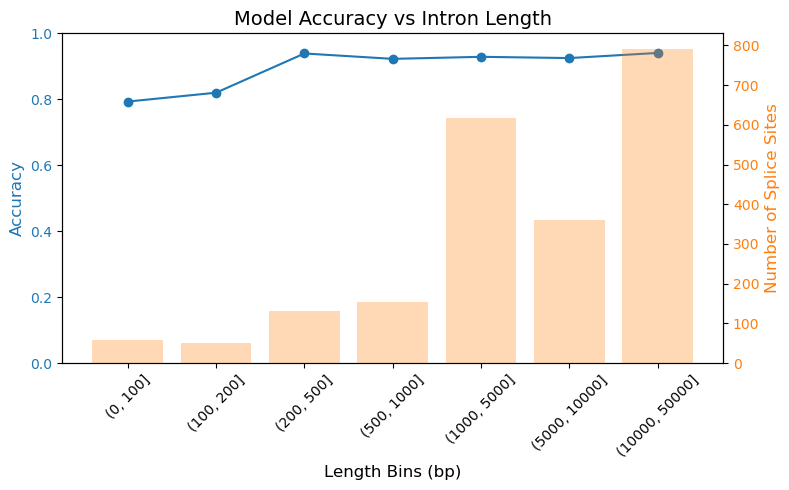

In [ ]:
# Group by bin and count correct predictions
grouped = splice_sites_expanded.groupby('length_bin').apply(
    lambda df: pd.Series({
        'total_sites': len(df),
        'correct_predictions': np.sum(df['label'] == df['predicted_label'])
    })
)
grouped['accuracy'] = grouped['correct_predictions'] / grouped['total_sites']
grouped.reset_index(inplace=True)
grouped.head()

# Plot accuracy vs transcript length bins as lineplot, and number of sites as barplot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(
    grouped['length_bin'].astype(str),
    grouped['accuracy'],
    marker='o',
    color='tab:blue',
    label='Accuracy'
)
ax2.bar(
    grouped['length_bin'].astype(str),
    grouped['total_sites'],
    alpha=0.3,
    color='tab:orange',
    label='Number of Sites'
)
ax1.set_xlabel('Length Bins (bp)', fontsize=12)
ax1.set_ylabel('Accuracy', color='tab:blue', fontsize=12)
ax2.set_ylabel('Number of Splice Sites', color='tab:orange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylim(0, 1)
#ax2.set_yscale('log')
plt.title('Model Accuracy vs Intron Length', fontsize=14)
fig = plt.gcf()
fig.tight_layout()
plt.show()


## Splice usage regression

Splice usage prediction performance on the test data.

In [ ]:
# Calculate the mean squared error for each species, tissue and timepoint
from sklearn.metrics import mean_squared_error
mse_dict = {}
conds = meta['conditions']
species = meta_df['species_id']
for sp in set(species):
    sp_indices = [i for i, s in enumerate(species) if s == sp]
    sp_n = species_id_to_name[sp]
    for i, _ in enumerate(conds):
        id = f"{sp_n}_{conds[i]}"
        true_sse_ = true_sse[sp_indices, :, i]
        pred_sse_ = pred_sse[sp_indices, :, i]
        # Replace NaN values in true_sse_ with 0
        true_sse_ = np.nan_to_num(true_sse_)
        # Select non-NaN values
        mask = ~np.isnan(true_sse_)
        true_sse_vals = true_sse_[mask]
        pred_sse_vals = pred_sse_[mask]
        mse = mean_squared_error(true_sse_vals, pred_sse_vals)
        mse_dict[id] = mse

# Make a dataframe: species, tissue, timepoint, mse
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['Sample', 'MSE'])
mse_df[['Species', 'Tissue', 'Timepoint']] = mse_df['Sample'].str.split('_', expand=True)
mse_df['Timepoint'] = mse_df['Timepoint'].astype(int)
mse_df.sort_values(['Species', 'Tissue', "Timepoint"], ascending=True, inplace=True)
mse_df

,Sample,MSE,Species,Tissue,Timepoint
0,mouse_Brain_1,0.002908,mouse,Brain,1
6,mouse_Brain_2,0.002258,mouse,Brain,2
7,mouse_Brain_3,0.001479,mouse,Brain,3
8,mouse_Brain_4,0.002166,mouse,Brain,4
9,mouse_Brain_5,0.001954,mouse,Brain,5
...,...,...,...,...,...
177,rat_Testis_10,0.002619,rat,Testis,10
178,rat_Testis_11,0.002599,rat,Testis,11
179,rat_Testis_12,0.002503,rat,Testis,12
180,rat_Testis_13,0.003244,rat,Testis,13


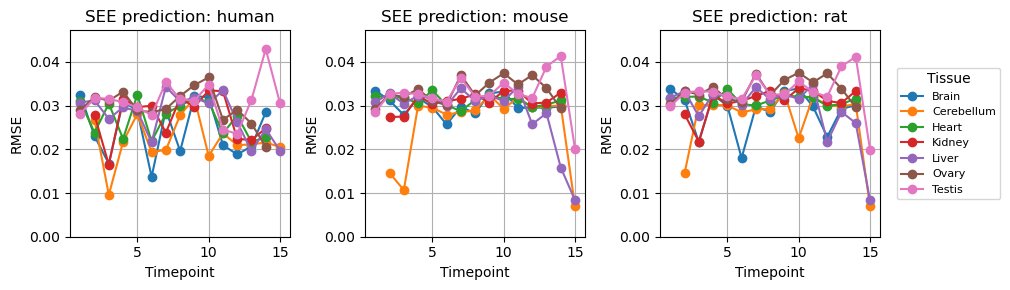

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
species_list = mse_df['Species'].unique()
for i, species in enumerate(species_list):
    plt.subplot(1, len(species_list), i + 1)
    for tissue in mse_df[mse_df['Species'] == species]['Tissue'].unique():
        tissue_data = mse_df[(mse_df['Species'] == species) & (mse_df['Tissue'] == tissue)]
        plt.plot(
            tissue_data['Timepoint'].astype(int),
            np.sqrt(tissue_data['MSE']),
            marker='o',
            label=tissue
        )
    plt.title(f'SEE prediction: {species}', fontsize=12)
    plt.xlabel('Timepoint', fontsize=10)
    plt.ylabel('RMSE', fontsize=10)
    plt.ylim(0, np.sqrt(mse_df['MSE']).max() * 1.1)
    plt.grid()
plt.tight_layout()
plt.legend(title='Tissue', fontsize=8, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()


Select interesting example to show

In [ ]:
# For every sequence, identify positions that are not NaN in all tissues, then compare values
num_sequences = true_sse.shape[0]
num_positions = true_sse.shape[1]
num_tissues = true_sse.shape[2]

matched_positions = {}

for seq_idx in range(num_sequences):
    # Find positions where all tissues are not NaN for this sequence
    valid_positions = np.where(np.all(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    # Find positions where at least one tissue is not NaN for this sequence
    # valid_positions = np.where(np.any(~np.isnan(true_sse[seq_idx, :, :]), axis=1))[0]
    if len(valid_positions) == 0:
        continue
    for pos in valid_positions:
        true_vals = true_sse[seq_idx, pos, :]
        pred_vals = pred_sse[seq_idx, pos, :]
        true_vals = np.nan_to_num(true_vals)
        matched_positions[(seq_idx, pos)] = { "true": true_vals, "pred": pred_vals }

# Combine all matched positions into a single dataframe for plotting
import pandas as pd
all_data = []
for (seq_idx, pos), vals in matched_positions.items():
    for tissue_idx in range(num_tissues):
        all_data.append({
            'sequence': seq_idx,
            'position': pos,
            'group': conds[tissue_idx],
            'true_SSE': vals['true'][tissue_idx],
            'pred_SSE': vals['pred'][tissue_idx]
        })  

all_data_df = pd.DataFrame(all_data)
all_data_df['Tissue'] = all_data_df['group'].apply(lambda x: x.split('_')[0])
all_data_df['Timepoint'] = all_data_df['group'].apply(lambda x: int(x.split('_')[1]))
all_data_df

,sequence,position,group,true_SSE,pred_SSE,Tissue,Timepoint
0,7,198,Brain_1,1.000,0.656959,Brain,1
1,7,198,Brain_10,0.979,0.693360,Brain,10
2,7,198,Brain_11,0.933,0.654246,Brain,11
3,7,198,Brain_12,1.000,0.372189,Brain,12
4,7,198,Brain_13,0.947,0.638484,Brain,13
...,...,...,...,...,...,...,...
4408280,52832,541,Testis_5,1.000,0.509768,Testis,5
4408281,52832,541,Testis_6,1.000,0.506001,Testis,6
4408282,52832,541,Testis_7,0.980,0.595524,Testis,7
4408283,52832,541,Testis_8,1.000,0.519733,Testis,8


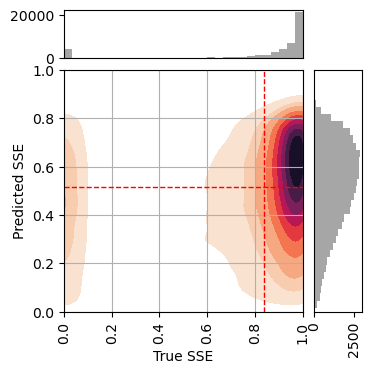

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

samples = all_data_df['group'].unique()[0:1] # Only one timepoint
axes = {}
num_tissues = len(samples)
num_cols = 1
num_rows = (num_tissues + num_cols - 1) // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4), squeeze=False)

for i, tissue in enumerate(samples):
    tissue_data = all_data_df[all_data_df['group'] == tissue]

    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # Scatter plot
    #ax.scatter(
    #    tissue_data['true_SSE'],
    #    tissue_data['pred_SSE'],
    #    alpha=0.2,
    #    s=4
    #)

    # 2d density plot
    sns.kdeplot(
        x=tissue_data['true_SSE'],
        y=tissue_data['pred_SSE'],
        levels=10,
        fill = True,
        cmap="rocket_r",
        ax=ax
    )

    # Top histogram (True SSE)
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histx.hist(
        tissue_data['true_SSE'],
        bins=30,
        color='gray',
        alpha=0.7
    )
    ax_histx.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

    # Right histogram (Pred SSE)
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    ax_histy.hist(
        tissue_data['pred_SSE'],
        bins=30,
        orientation='horizontal',
        color='gray',
        alpha=0.7
    )
    ax_histy.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

    plt.setp(ax_histy.get_xticklabels(), rotation=90, ha='center')
    plt.setp(ax.get_xticklabels(), rotation=90, ha='center')

    ax_histy.set_xlabel('')
    ax_histx.set_xlabel('')
    ax_histy.set_ylabel('')

    # Add mean lines
    mean_true = tissue_data['true_SSE'].mean()
    mean_pred = tissue_data['pred_SSE'].mean()
    ax.axvline(mean_true, color='red', linestyle='--', linewidth=1, label='Mean True')
    ax.axhline(mean_pred, color='red', linestyle='--', linewidth=1, label='Mean Pred')

    #ax.set_title(f'{tissue}', fontsize=10)
    ax.set_xlabel('True SSE', fontsize=10)
    ax.set_ylabel('Predicted SSE', fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid()

plt.tight_layout()


In [ ]:
# Group by sequence and position, and calculate correlation between true and predicted SSE values
correlation_results = []
for (seq_idx, pos, tissue), group in all_data_df.groupby(['sequence', 'position', 'Tissue']):
    true_vals = group['true_SSE'].values
    pred_vals = group['pred_SSE'].values
    if len(true_vals) < 2:
        continue
    correlation = np.corrcoef(true_vals, pred_vals)[0, 1]
    correlation_results.append({
        'sequence': seq_idx,
        'position': pos,
        'tissue': tissue,
        'correlation': correlation
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by='correlation', ascending=False)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,sequence,position,tissue,correlation
191803,32454,46,Kidney,0.991495
247915,41150,280,Kidney,0.989745
315906,51632,649,Kidney,0.989202
257393,42544,2,Kidney,0.988875
229953,38465,176,Kidney,0.988781
...,...,...,...,...
324062,52777,982,Liver,NaN
324069,52778,749,Liver,NaN
324076,52778,854,Liver,NaN
324083,52778,969,Liver,NaN


In [ ]:
# How many are NaN?
nas = correlation_df['correlation'].isna()
print(
    f"{nas.sum()} ({nas.mean() * 100:.2f}%) of the correlation values are NaN."
)

1678 (0.52%) of the correlation values are NaN.


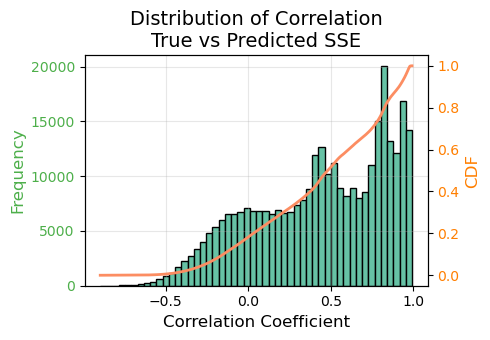

In [ ]:
# Cumulative distribution
sorted_corr = np.sort(correlation_df['correlation'].dropna())
cdf = np.arange(1, len(sorted_corr) + 1) / len(sorted_corr)

# Plot distribution of correlations
fig, ax1 = plt.subplots(figsize=(5, 3.5))
ax1.hist(correlation_df['correlation'].dropna(), bins=50, color='#66c2a5', edgecolor='black')
ax1.set_xlabel('Correlation Coefficient', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12, color='#4daf4a')
ax1.tick_params(axis='y', labelcolor='#4daf4a')

ax2 = ax1.twinx()
ax2.plot(sorted_corr, cdf, color='#fc8d62', linewidth=2, label='CDF')
ax2.set_ylabel('CDF', fontsize=12, color='#ff7f00')
ax2.tick_params(axis='y', labelcolor='#ff7f00')

plt.title('Distribution of Correlation\nTrue vs Predicted SSE', fontsize=14)
ax1.grid(alpha=0.3)
fig.tight_layout()
plt.show()

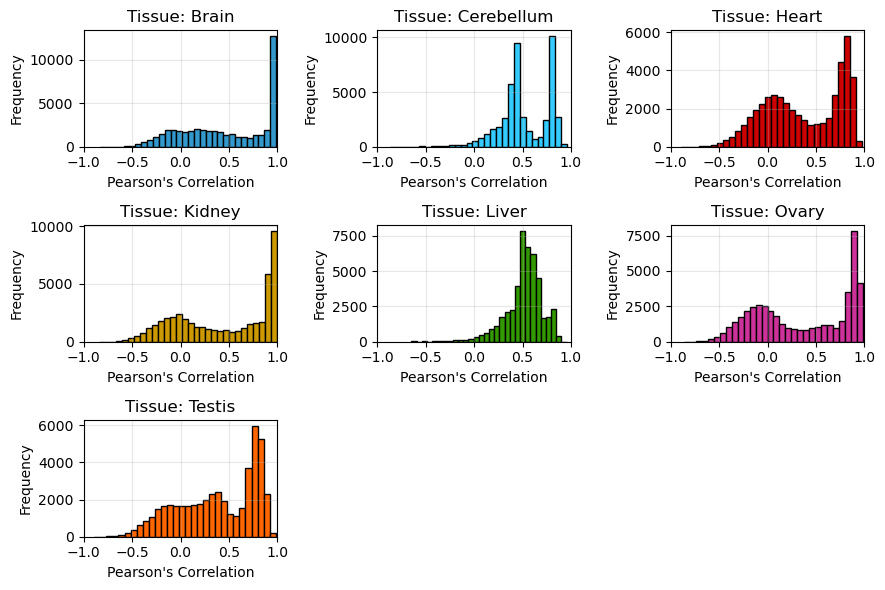

In [ ]:
# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

unique_tissues = all_data_df['Tissue'].unique()
num_tissues = len(unique_tissues)
num_cols = 3
num_rows = (num_tissues + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2), squeeze=False)
for i, tissue in enumerate(unique_tissues):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    tissue_corrs = correlation_df[correlation_df['tissue'] == tissue]['correlation'].dropna()
    tissue_color = tissue_colors.get(tissue, '#000000')
    ax.hist(tissue_corrs, bins=30, color=tissue_color, edgecolor='black')
    ax.set_title(f'Tissue: {tissue}', fontsize=12)
    ax.set_xlabel("Pearson's Correlation", fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_xlim(-1, 1)
    ax.grid(alpha=0.3)
plt.tight_layout()
for j in range(i + 1, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    fig.delaxes(axs[row][col])
plt.show()

In [ ]:
top_examples = correlation_df.sort_values(by='correlation', ascending=False)[1:8]
top_examples

,sequence,position,tissue,correlation
247915,41150,280,Kidney,0.989745
315906,51632,649,Kidney,0.989202
257393,42544,2,Kidney,0.988875
229953,38465,176,Kidney,0.988781
243092,40475,195,Kidney,0.988658
289516,47756,772,Kidney,0.988505
310271,50861,199,Kidney,0.987863


In [ ]:
plot_df = all_data_df[(all_data_df['sequence'].isin(top_examples['sequence'])) & (all_data_df['position'].isin(top_examples['position']))]
plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('_')[0])
plot_df['timepoint'] = plot_df['group'].apply(lambda x: x.split('_')[1])
plot_df

/tmp/ipykernel_2192392/3557751785.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
/tmp/ipykernel_2192392/3557751785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['tissue'] = plot_df['group'].apply(lambda x: x.split('_')[0])
/tmp/ipykernel_2192392/3557751785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,sequence,position,group,true_SSE,pred_SSE,Tissue,Timepoint,site,tissue,timepoint
3120750,38465,176,Brain_1,0.946,0.845614,Brain,1,38465_176,Brain,1
3120751,38465,176,Brain_10,0.909,0.838255,Brain,10,38465_176,Brain,10
3120752,38465,176,Brain_11,0.910,0.804354,Brain,11,38465_176,Brain,11
3120753,38465,176,Brain_12,0.000,0.457973,Brain,12,38465_176,Brain,12
3120754,38465,176,Brain_13,0.871,0.780704,Brain,13,38465_176,Brain,13
...,...,...,...,...,...,...,...,...,...,...
4287345,51632,649,Testis_5,0.923,0.752850,Testis,5,51632_649,Testis,5
4287346,51632,649,Testis_6,0.880,0.754461,Testis,6,51632_649,Testis,6
4287347,51632,649,Testis_7,0.821,0.812059,Testis,7,51632_649,Testis,7
4287348,51632,649,Testis_8,0.800,0.760329,Testis,8,51632_649,Testis,8


/tmp/ipykernel_2192392/6538556.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)


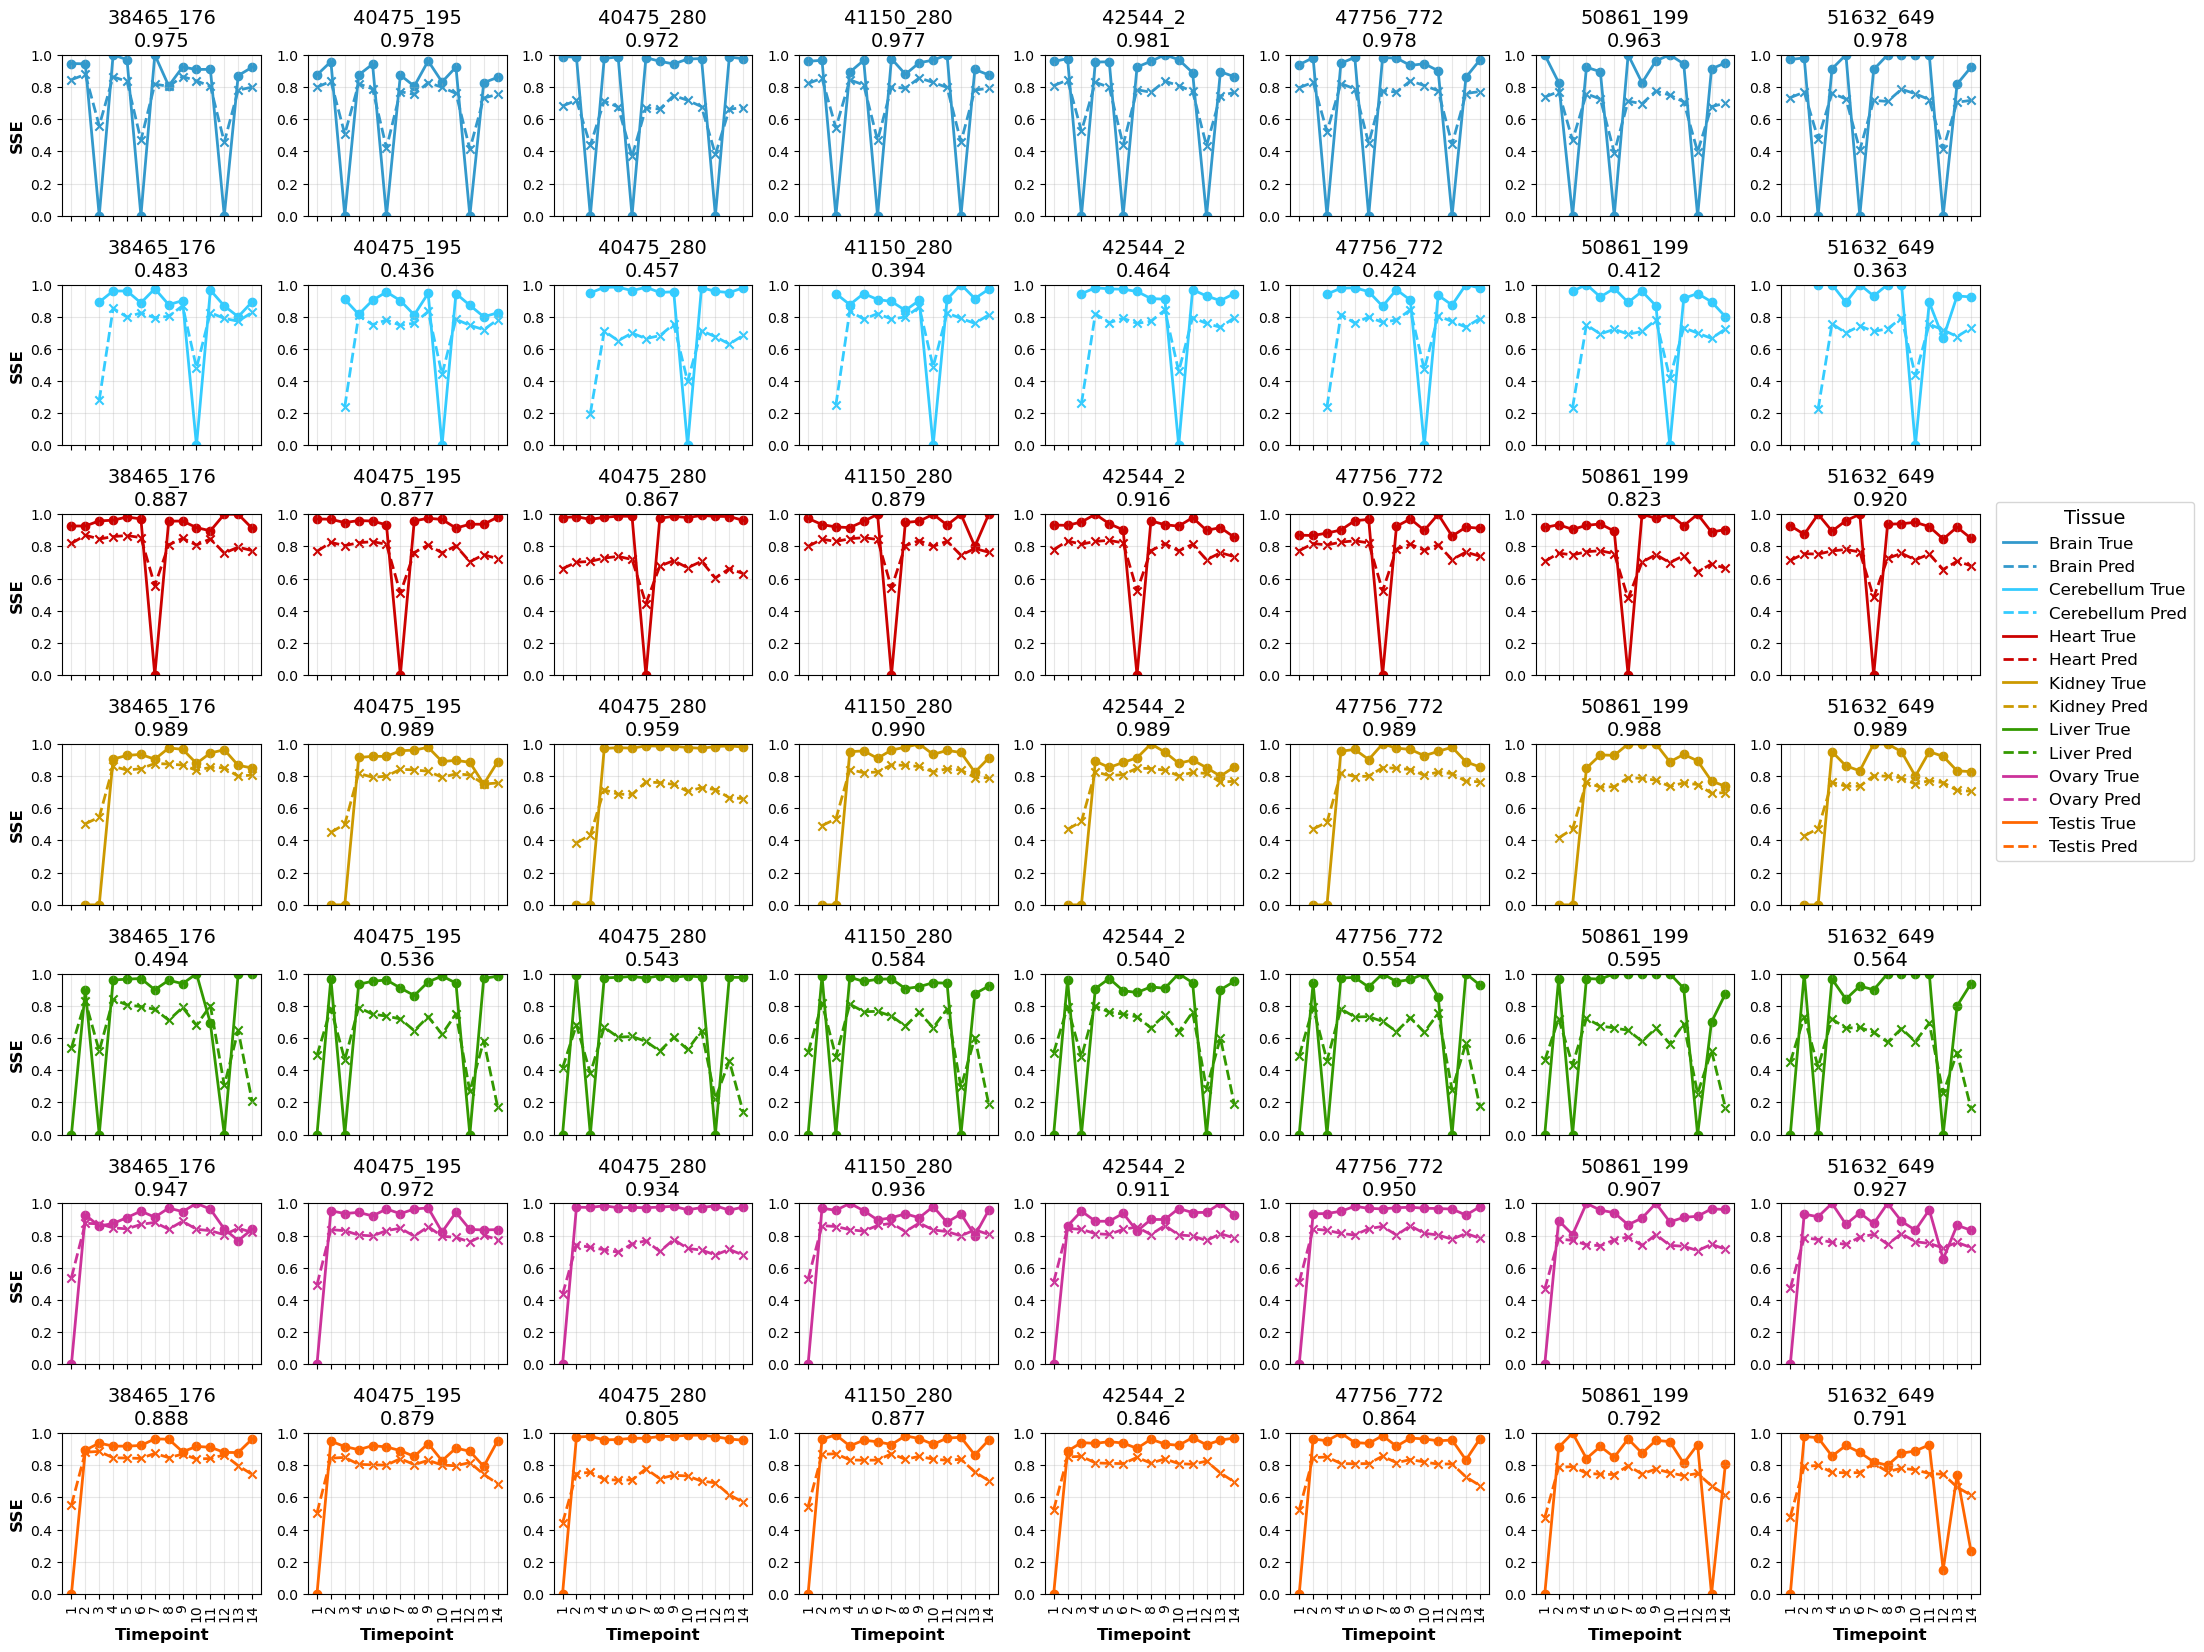

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

unique_sites = plot_df['site'].unique()
smooth = False

timepoint_order = sorted(plot_df['timepoint'].unique(), key=lambda x: int(''.join(filter(str.isdigit, x))))
plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)

n_sites = len(unique_sites)
n_tissues = len(plot_df['tissue'].unique())
fig, axes = plt.subplots(n_tissues, n_sites, figsize=(2.5 * n_sites, 2.5 * n_tissues), sharex='col')

if n_sites == 1 and n_tissues == 1:
    axes = axes.reshape(1, 1)
elif n_sites == 1:
    axes = axes.reshape(n_tissues, 1)
elif n_tissues == 1:
    axes = axes.reshape(1, n_sites)

legend_handles, legend_labels = [], []

for col_idx, site in enumerate(unique_sites):
    site_data = plot_df[plot_df['site'] == site]
    for tissue in site_data['tissue'].unique():
        row_idx = list(plot_df['tissue'].unique()).index(tissue)
        tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
        color = tissue_colors.get(tissue, '#000000')
        x_values = tissue_data['timepoint'].cat.codes
        y_sse_true = tissue_data['true_SSE'].values
        y_sse_pred = tissue_data['pred_SSE'].values
        correlation = np.corrcoef(y_sse_true, y_sse_pred)[0, 1]

        def smooth_spline(x, y):
            if smooth and len(x) > 3:
                x_dense = np.linspace(x.min(), x.max(), 100)
                if len(np.unique(x)) < 4:
                    return x, y
                spline = make_interp_spline(x, y, k=2)
                y_smooth = spline(x_dense)
                return x_dense, y_smooth
            else:
                return x, y

        # True SSE: solid line
        x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
        line_true, = axes[row_idx, col_idx].plot(x_sse, y_sse_true_smooth, label=f'{tissue} True', color=color, linewidth=2, linestyle='-')
        axes[row_idx, col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)

        # Predicted SSE: dashed line
        x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
        line_pred, = axes[row_idx, col_idx].plot(x_sse, y_sse_pred_smooth, label=f'{tissue} Pred', color=color, linewidth=2, linestyle='--')
        axes[row_idx, col_idx].scatter(x_values, y_sse_pred, color=color, marker='x', s=36)

        if col_idx == 0:
            legend_handles.extend([line_true, line_pred])
            legend_labels.extend([f'{tissue} True', f'{tissue} Pred'])

        axes[row_idx, col_idx].set_ylim(0, 1)
        axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14)
        axes[row_idx, col_idx].set_xticks(range(len(timepoint_order)))
        axes[row_idx, col_idx].set_xticklabels(timepoint_order, rotation=90)
        axes[row_idx, col_idx].grid(True, alpha=0.3)

# Set y labels for first column
for row_idx in range(n_tissues):
    axes[row_idx, 0].set_ylabel('SSE', fontsize=12, fontweight='bold')

# Set x labels for last row
for col_idx in range(n_sites):
    axes[-1, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')

fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
           title='Tissue', title_fontsize=14, fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
